An Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.
Goal is to build a model to predict whether a customer would be interested in Vehicle Insurance.
The evaluation metric for this hackathon is ROC_AUC score.

In [1]:
# Import necessary Libraries
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 10)
% matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

Load Data

In [2]:
df_train = pd.read_csv('train.csv', header=0)
df_test = pd.read_csv('test.csv', header=0)
df_submission = pd.read_csv('sample_submission_iA3afxn.csv', header=0)

In [3]:
print(df_train.shape, df_test.shape)

(381109, 12) (127037, 11)


In [4]:
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [5]:
df_test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


Quick Exploratory Data Analysis

In [6]:
# Nulls Check
df_train.isnull().sum()

# No missing values

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

0    334399
1     46710
Name: Response, dtype: int64
0.877436638861848 0.12256336113815208


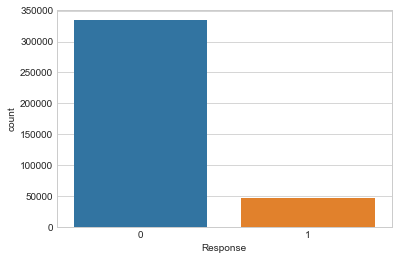

In [7]:
# Target Variable Analysis
sns.countplot(data=df_train, x='Response')
print(df_train['Response'].value_counts())
print(df_train[df_train['Response']==0].shape[0]/df_train.shape[0], df_train[df_train['Response']==1].shape[0]/df_train.shape[0])

# Data is highly imbalanced in the ratio of 22:3
# Will need to perform over sampling to get better class level and ROC-AUC scores

In [8]:
#df_train['train_flag'] = 1
#df_test['train_flag'] = 0

#df_data = pd.concat((df_train, df_test))
#print(df_data.shape)

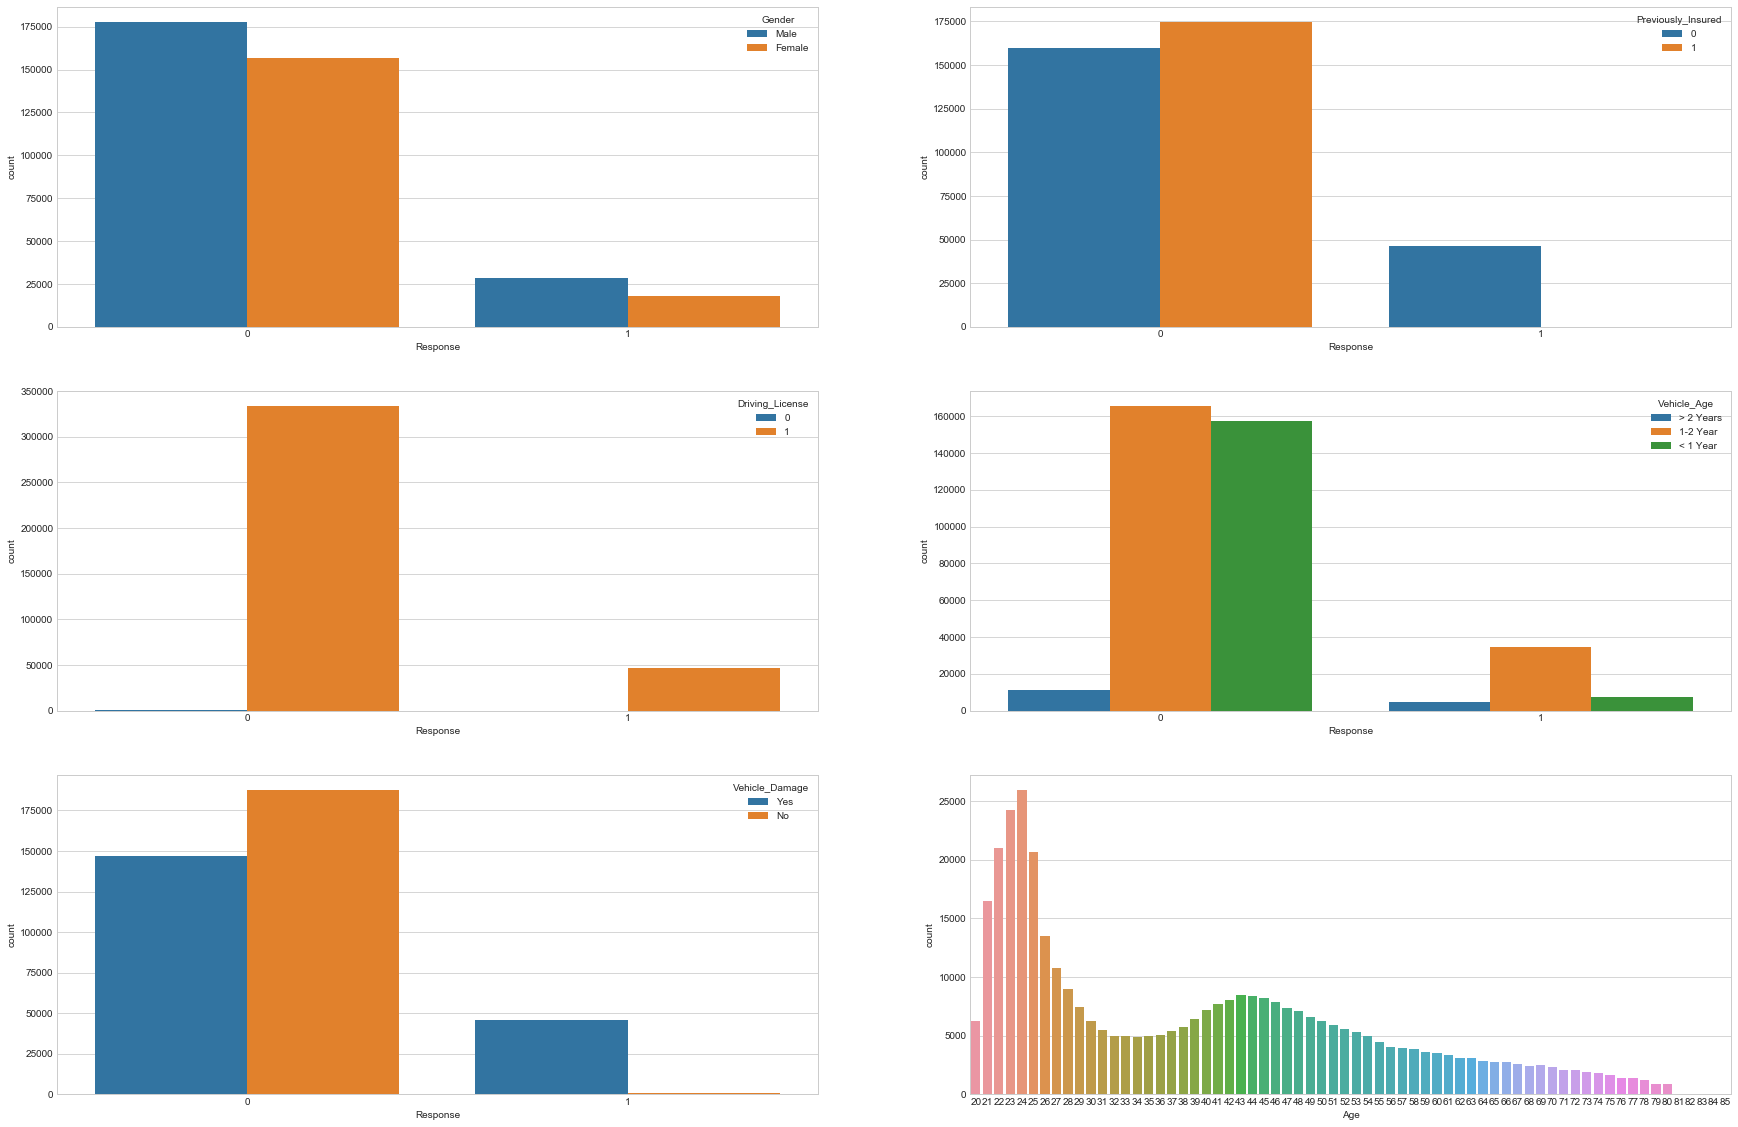

In [9]:
plt.figure(1, figsize=(30,20))
plt.subplot(321)
sns.countplot(x='Response', hue='Gender', data=df_train) # Response by Gender
plt.subplot(322)
sns.countplot(x='Response', hue='Previously_Insured', data=df_train) # Response by Previously Insured
plt.subplot(323)
sns.countplot(x='Response', hue='Driving_License', data=df_train) # Response by Driving license

plt.subplot(324)
sns.countplot(x='Response', hue='Vehicle_Age', data=df_train) # Response by Vehicles age
plt.subplot(325)
sns.countplot(x='Response', hue='Vehicle_Damage', data=df_train) # Response by Vehicles Damage
plt.subplot(326)
sns.countplot(x='Age', data=df_train) # Distribution by ages

Data Preparation

In [10]:
# Binary Categorical Variables
df_train['Gender'] = df_train['Gender'].replace({'Female':1, 'Male':0})
df_test['Gender'] = df_test['Gender'].replace({'Female':1, 'Male':0})

df_train['Vehicle_Damage'] = df_train['Vehicle_Damage'].replace({'Yes':1, 'No':0})
df_test['Vehicle_Damage'] = df_test['Vehicle_Damage'].replace({'Yes':1, 'No':0})

In [11]:
# Ordinal Categorical Variables
order = {'< 1 Year':0, '1-2 Year':1, '> 2 Years':2}
df_train['Vehicle_Age'] = df_train['Vehicle_Age'].map(order)
df_test['Vehicle_Age'] = df_test['Vehicle_Age'].map(order)

In [12]:
#from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()
#df_data['Segmentation'] = le.fit_transform(df_data['Segmentation'])
#list(le.classes_)

In [13]:
# Handling Missing Values
#train.fillna(-999, inplace=True)
#test.fillna(-999, inplace=True)

In [14]:
# Now that all the features are in numeric form, check the correlation between features
df_train.corr()

# Vehicle_Damage, Previously_Insured and then Vehicle_Age features have the greatest corr to the target variable

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,1.000000,-0.000999,0.001561,-0.000564,-0.000572,0.002457,0.000878,-0.001507,0.003027,-0.002837,-0.000630,-0.001368
Gender,-0.000999,1.000000,-0.145545,0.018374,-0.000604,0.081932,-0.160427,-0.091606,-0.003673,0.111159,0.002517,-0.052440
Age,0.001561,-0.145545,1.000000,-0.079782,0.042574,-0.254682,0.765790,0.267534,0.067507,-0.577826,-0.001264,0.111147
Driving_License,-0.000564,0.018374,-0.079782,1.000000,-0.001081,0.014969,-0.037306,-0.016622,-0.011906,0.043731,-0.000848,0.010155
Region_Code,-0.000572,-0.000604,0.042574,-0.001081,1.000000,-0.024659,0.043778,0.028235,-0.010588,-0.042420,-0.002750,0.010570
Previously_Insured,0.002457,0.081932,-0.254682,0.014969,-0.024659,1.000000,-0.380873,-0.824143,0.004269,0.219381,0.002537,-0.341170
Vehicle_Age,0.000878,-0.160427,0.765790,-0.037306,0.043778,-0.380873,1.000000,0.396873,0.041580,-0.550663,-0.001892,0.221874
Vehicle_Damage,-0.001507,-0.091606,0.267534,-0.016622,0.028235,-0.824143,0.396873,1.000000,0.009349,-0.224377,-0.002064,0.354400
Annual_Premium,0.003027,-0.003673,0.067507,-0.011906,-0.010588,0.004269,0.041580,0.009349,1.000000,-0.113247,-0.000608,0.022575
Policy_Sales_Channel,-0.002837,0.111159,-0.577826,0.043731,-0.042420,0.219381,-0.550663,-0.224377,-0.113247,1.000000,0.000002,-0.139042


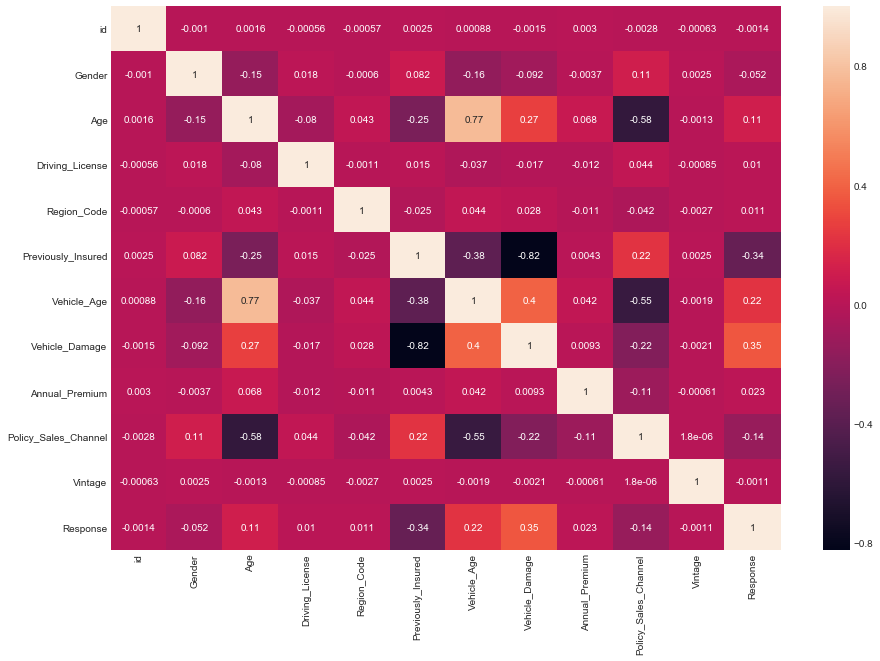

In [15]:
# Heatmap to see correlation between each pair of columns
plt.subplots(figsize = (15,10))
sns.heatmap(df_train.corr(), annot=True)

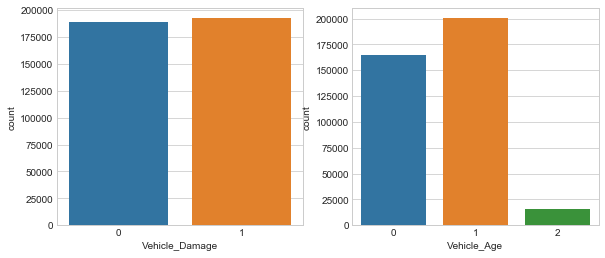

In [16]:
plt.figure(1, figsize=(15,4))
plt.subplot(131)
sns.countplot(x='Vehicle_Damage', data=df_train)
plt.subplot(132)
sns.countplot(x='Vehicle_Age', data=df_train)

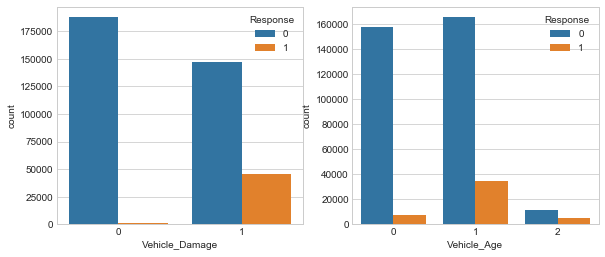

In [17]:
plt.figure(1, figsize=(15,4))
plt.subplot(131)
sns.countplot(x='Vehicle_Damage', hue='Response', data=df_train)
plt.subplot(132)
sns.countplot(x='Vehicle_Age', hue='Response', data=df_train)

In [18]:
# Drop Vintage column since it doe not have too much relevance to the target variable
df_train_copy = df_train.copy()
df_train_copy.drop(['Vintage'], axis=1, inplace=True) # 'id',
df_train_copy.head()

df_test.drop(['Vintage'], axis=1, inplace=True) # 'id',

Balance Datasets

In [19]:
from sklearn.utils import resample, shuffle

df_majority = df_train_copy[df_train_copy['Response']==0]
df_minority = df_train_copy[df_train_copy['Response']==1]
df_minority_upsampled = resample(df_minority, replace=True, n_samples=334399, random_state = 1)
balanced_df = pd.concat([df_minority_upsampled, df_majority])
balanced_df = shuffle(balanced_df)
balanced_df['Response'].value_counts()

1    334399
0    334399
Name: Response, dtype: int64

In [20]:
df_train = balanced_df.copy()

In [21]:
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Response
38043,38044,1,20,1,8.0,0,0,1,95824.0,160.0,0
83732,83733,1,20,1,36.0,1,0,0,42293.0,160.0,0
80979,80980,1,23,1,28.0,0,0,1,37906.0,124.0,1
303380,303381,1,49,1,28.0,0,2,1,36451.0,163.0,1
228934,228935,0,39,1,41.0,0,1,1,35506.0,124.0,1


Feature Engineering

In [22]:
df_train['premium_by_age'] = df_train['Annual_Premium']/df_train['Age']
df_test['premium_by_age'] = df_test['Annual_Premium']/df_test['Age']

#df_train['premium_by_vintage'] = df_train['Annual_Premium']/df_train['Vintage']
#df_test['premium_by_vintage'] = df_test['Annual_Premium']/df_test['Vintage']

In [23]:
# Annual Premium by Gender
df_train["id_mean_premium"] = df_train.groupby(['Gender'])['Annual_Premium'].transform('mean')
gender_mean_dict = df_train.groupby(['Gender'])['Annual_Premium'].mean().to_dict()
df_test['id_mean_premium'] = df_test['Gender'].apply(lambda x:gender_mean_dict.get(x,0))

# Response by Gender
df_train["response_by_gender"] = df_train.groupby(['Gender'])['Response'].transform('mean')
response_by_gender_dict = df_train.groupby(['Gender'])['Response'].mean().to_dict()
df_test['response_by_gender'] = df_test['Gender'].apply(lambda x:response_by_gender_dict.get(x,0))

# Response by Age
df_train["response_by_age"] = df_train.groupby(['Age'])['Response'].transform('mean')
response_by_age_dict = df_train.groupby(['Age'])['Response'].mean().to_dict()
df_test['response_by_age'] = df_test['Age'].apply(lambda x:response_by_age_dict.get(x,0))

# Response by Policy Channel
df_train["response_by_channel"] = df_train.groupby(['Policy_Sales_Channel'])['Response'].transform('mean')
response_by_channel_dict = df_train.groupby(['Policy_Sales_Channel'])['Response'].mean().to_dict()
df_test['response_by_channel'] = df_test['Policy_Sales_Channel'].apply(lambda x:response_by_channel_dict.get(x,0))

# Response by Previously Insured
df_train["response_by_prev_insured"] = df_train.groupby(['Previously_Insured'])['Response'].transform('mean')
response_by_prev_insured_dict = df_train.groupby(['Previously_Insured'])['Response'].mean().to_dict()
df_test['response_by_prev_insured'] = df_test['Previously_Insured'].apply(lambda x:response_by_prev_insured_dict.get(x,0))

# Response by Region Code
df_train["response_by_region"] = df_train.groupby(['Region_Code'])['Response'].transform('mean')
response_by_region_dict = df_train.groupby(['Region_Code'])['Response'].mean().to_dict()
df_test['response_by_region'] = df_test['Region_Code'].apply(lambda x:response_by_region_dict.get(x,0))

# Response by Vehicle Age
df_train["response_by_veh_age"] = df_train.groupby(['Vehicle_Age'])['Response'].transform('mean')
response_by_veh_age_dict = df_train.groupby(['Vehicle_Age'])['Response'].mean().to_dict()
df_test['response_by_veh_age'] = df_test['Vehicle_Age'].apply(lambda x:response_by_veh_age_dict.get(x,0))

# Response by Vehicle Damage
df_train["response_by_veh_damage"] = df_train.groupby(['Vehicle_Damage'])['Response'].transform('mean')
response_by_veh_damage_dict = df_train.groupby(['Vehicle_Damage'])['Response'].mean().to_dict()
df_test['response_by_veh_damage'] = df_test['Vehicle_Damage'].apply(lambda x:response_by_veh_damage_dict.get(x,0))

In [24]:
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Response,premium_by_age,id_mean_premium,response_by_gender,response_by_age,response_by_channel,response_by_prev_insured,response_by_region,response_by_veh_age,response_by_veh_damage
38043,38044,1,20,1,8.0,0,0,1,95824.0,160.0,0,4791.200000,30875.731197,0.454121,0.164231,0.133737,0.675729,0.431879,0.246266,0.690588
83732,83733,1,20,1,36.0,1,0,0,42293.0,160.0,0,2114.650000,30875.731197,0.454121,0.164231,0.133737,0.006452,0.374739,0.246266,0.035985
80979,80980,1,23,1,28.0,0,0,1,37906.0,124.0,1,1648.086957,30875.731197,0.454121,0.216657,0.625175,0.675729,0.622398,0.246266,0.690588
303380,303381,1,49,1,28.0,0,2,1,36451.0,163.0,1,743.897959,30875.731197,0.454121,0.635772,0.754990,0.675729,0.622398,0.749129,0.690588
228934,228935,0,39,1,41.0,0,1,1,35506.0,124.0,1,910.410256,31130.973816,0.534553,0.657921,0.625175,0.675729,0.496989,0.600858,0.690588


One Hot Encode all categorical variables

In [25]:
# One hot encoding of all the categorical vars
df_train = pd.get_dummies(data=df_train, columns=['Gender','Vehicle_Age','Vehicle_Damage','Driving_License','Previously_Insured'])
df_test = pd.get_dummies(data=df_test, columns=['Gender','Vehicle_Age','Vehicle_Damage','Driving_License','Previously_Insured'])

print(df_train.shape)
print(df_test.shape)
df_train.head()

(668798, 26)
(127037, 25)


,id,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Response,premium_by_age,id_mean_premium,response_by_gender,response_by_age,...,Gender_1,Vehicle_Age_0,Vehicle_Age_1,Vehicle_Age_2,Vehicle_Damage_0,Vehicle_Damage_1,Driving_License_0,Driving_License_1,Previously_Insured_0,Previously_Insured_1
38043,38044,20,8.0,95824.0,160.0,0,4791.200000,30875.731197,0.454121,0.164231,...,1,1,0,0,0,1,0,1,1,0
83732,83733,20,36.0,42293.0,160.0,0,2114.650000,30875.731197,0.454121,0.164231,...,1,1,0,0,1,0,0,1,0,1
80979,80980,23,28.0,37906.0,124.0,1,1648.086957,30875.731197,0.454121,0.216657,...,1,1,0,0,0,1,0,1,1,0
303380,303381,49,28.0,36451.0,163.0,1,743.897959,30875.731197,0.454121,0.635772,...,1,0,0,1,0,1,0,1,1,0
228934,228935,39,41.0,35506.0,124.0,1,910.410256,31130.973816,0.534553,0.657921,...,0,0,1,0,0,1,0,1,1,0


Split data into training and validation sets

In [26]:
from sklearn.model_selection import train_test_split

X = df_train.drop(columns='Response', axis=1)
y = df_train['Response']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)
print('X_train:', X_train.shape)
print('X_val:', X_val.shape)
print('y_train:', y_train.shape)
print('y_val:', y_val.shape)

X_test = df_test

X_train: (501598, 25)
X_val: (167200, 25)
y_train: (501598,)
y_val: (167200,)


Scale all the training columns

In [27]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#std_scaler = StandardScaler()
#X_train = std_scaler.fit_transform(X_train)
#X_val = std_scaler.transform(X_val)
#X_test = std_scaler.transform(X_test)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Model Creation and Evaluation

In [28]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, recall_score

In [29]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Create the Logistic Regression model object
logreg_model = LogisticRegression(random_state=1)
logreg_model.fit(X_train, y_train)

lr_pred = logreg_model.predict(X_val)

print('LR-Training Score:', logreg_model.score(X_train, y_train))
print('LR-Validation Score:', logreg_model.score(X_val, y_val))
print('LR ROC-AUC score:', 100*roc_auc_score(y_val, lr_pred).round(2))

LR-Training Score: 0.7968672123892041
LR-Validation Score: 0.7954964114832536
LR ROC-AUC score: 80.0


In [30]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=1)
dtc = dtc.fit(X_train, y_train)

dtc_pred = logreg_model.predict(X_val)

print('DTC-Training Score:', dtc.score(X_train, y_train))
print('DTC-Validation Score:', dtc.score(X_val, y_val))
print('DTC ROC-AUC score:', 100*roc_auc_score(y_val, dtc_pred).round(2))

DTC-Training Score: 1.0
DTC-Validation Score: 0.9393720095693779
DTC ROC-AUC score: 80.0


In [32]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=1)
rfc = rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_val)

print('RFC-Training Score:', rfc.score(X_train, y_train))
print('RFC-Validation Score:', rfc.score(X_val, y_val))
print('RFC ROC-AUC score:', 100*roc_auc_score(y_val, rfc_pred).round(2))

#y_pred = rfr.predict(X_test)

RFC-Training Score: 1.0
RFC-Validation Score: 0.9445454545454546
RFC ROC-AUC score: 94.0


In [34]:
from sklearn.ensemble import RandomForestClassifier
rfc100 = RandomForestClassifier(n_estimators=100)
rfc100.fit(X_train, y_train)

rfc100_pred = rfc100.predict(X_val)

print('RFC-Training Score:', rfc100.score(X_train, y_train))
print('RFC-Validation Score:', rfc100.score(X_val, y_val))
print('RFC100 ROC-AUC score:', 100*roc_auc_score(y_val, rfc100_pred).round(2))

RFC-Training Score: 1.0
RFC-Validation Score: 0.9451255980861244
RFC100 ROC-AUC score: 94.0


In [40]:
## FINAL MODEL SELECTED FOR SUBMISSION

# Lets try to boost the performance of Logistic Regression classifiers AdaBoost Classification Ensemble model
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(n_estimators=100, base_estimator=logreg_model, learning_rate=0.2, random_state=1)
abc = abc.fit(X_train, y_train)

abc_pred = abc.predict(X_val)

print('ABC-Training Score:', abc.score(X_train, y_train))
print('ABC-Validation Score:', abc.score(X_val, y_val))
print('ABC ROC-AUC score:', 100*roc_auc_score(y_val, abc_pred).round(2))

ABC-Training Score: 0.7948496604850896
ABC-Validation Score: 0.794037081339713
ABC ROC-AUC score: 79.0


Create Submission File

In [41]:
# Predict for test data and add to submission file
y_pred = abc.predict(X_test)

# Create submission df with test IDs
df_submission = pd.DataFrame()
df_submission['id'] = df_test['id']
df_submission['Response'] = y_pred

# Write to submission file
df_submission.to_csv(r'C:\Users\Shilpa\Desktop\cross_sell_submission.csv', index=False, header=True)

df_submission['Response'].value_counts()

0    73166
1    53871
Name: Response, dtype: int64

Conclusion: 
Achieved AUC-ROC score of 79.99 on the leaderboard using AdaBoost Ensemble with base model of Logistic Regression. Though the accuracy score on validation data is very High for Decision Tree and Random Forest, Logistic Regression did much beeter on test data than either of these